# 预测波士顿房价

## 在 SageMaker 中使用 XGBoost（超参数优化）

_机器学习工程师纳米学位课程 | 部署_

---

为了介绍 SageMaker 的高阶 Python API，我们将查看一个相对简单的问题。我们将使用[波士顿房价数据集](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)预测波士顿地区的房价中位数。

高阶 API 的文档位于 [ReadTheDocs 页面](http://sagemaker.readthedocs.io/en/latest/)

## 一般步骤

通常，在 notebook 实例中使用 SageMaker 时，你需要完成以下步骤。当然，并非每个项目都要完成每一步。此外，有很多步骤有很大的变化余地，你将在这些课程中发现这一点。

1. 下载或检索数据。
2. 处理/准备数据。
3. 将处理的数据上传到 S3。
4. 训练所选的模型。
5. 测试训练的模型（通常使用批转换作业）。
6. 部署训练的模型。
7. 使用部署的模型。

在此 notebook 中，我们仅介绍 1-5 步，因为我们只关心如何创建优化过的模型并测试模型性能。

## 第 0 步：设置 notebook

先进行必要的设置以运行 notebook。首先，加载所需的所有 Python 模块。

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

除了上面的模块之外，我们还需要导入将使用的各种 SageMaker 模块。

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## 第 1 步：下载数据

幸运的是，我们可以使用 sklearn 检索数据集，所以这一步相对比较简单。

In [3]:
boston = load_boston()

## 第 2 步：准备和拆分数据

因为使用的是整洁的表格数据，所以不需要进行任何处理。但是，我们需要将数据集中的各行拆分成训练集、测试集和验证集。

In [4]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## 第 3 步：将数据文件上传到 S3

使用 SageMaker 创建训练作业后，进行训练操作的容器会执行。此容器可以访问存储在 S3 上的数据。所以我们需要将用来训练的数据上传到 S3。此外，在执行批转换作业时，SageMaker 要求输入数据存储在 S3 上。我们可以使用 SageMaker API 完成这一步，它会在后台自动处理一些步骤。

### 将数据保存到本地

首先，我们需要创建测试、训练和验证 csv 文件，并将这些文件上传到 S3。

In [5]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
# We use pandas to save our test, train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and
# validation data, it is assumed that the first entry in each row is the target variable.

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### 上传到 S3

因为目前正在 SageMaker 会话中运行，所以可以使用代表此会话的对象将数据上传到默认的 S3 存储桶中。注意，建议提供自定义 prefix（即 S3 文件夹），以防意外地破坏了其他 notebook 或项目上传的数据。

In [7]:
prefix = 'boston-xgboost-tuning-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## 第 4 步：训练 XGBoost 模型

将训练和验证数据上传到 S3 后，我们可以构建 XGBoost 模型并训练它。在之前的 notebook 中，我们训练了一个模型，但是现在我们将使用 SageMaker 的超参数优化功能训练多个模型，并使用在验证集上表现最好的模型。

与之前的方法一样，首先需要构建一个 estimator 对象。

In [8]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

	get_image_uri(region, 'xgboost', '0.90-1').


在开始优化超参数之前，我们需要对不希望采用默认值的模型超参数进行设置。如果使用 XGBoost 算法，可以设置的超参数有很多，以下只是其中几个。如果你想修改下面的超参数或修改其他超参数，请参阅 [XGBoost 超参数页面](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)

In [9]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

完全设置好 estimator 对象后，下面创建超参数优化器。我们需要构建一个新的对象，其中包含我们希望 SageMaker 优化的参数。我们希望为 `max_depth`、`eta`、`min_child_weight`、`subsample` 和 `gamma` 参数设置最佳值。注意，对于我们希望 SageMaker 优化的每个参数，我们需要指定参数的类型和值范围。

此外，我们指定了要构建的模型数量 (`max_jobs`) 以及可以并行训练的模型数量 (`max_parallel_jobs`)。在以下单元格中，我们选择训练 `20` 个模型，并且一次并行训练 `3` 个。注意，总共有 `20` 个训练作业需要执行，可能需要一段时间，在此 notebook 中几乎达到半小时。模型越复杂，等待的时间越长。

In [10]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                               objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

完全设置好超参数优化器对象后，可以训练它了。我们需要告诉 SageMaker 输入数据是 csv 格式，然后调用 `fit` 方法。

In [11]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

我们已经在多个示例中看到，`fit()` 方法负责设置和拟合多个不同的模型，每个模型都采用不同的超参数。如果我们想等待此过程运行完毕，可以调用 `wait()` 方法。

In [12]:
xgb_hyperparameter_tuner.wait()

...........................................................................................................................................................................................................................................................................!


超参数优化器运行完毕后，我们可以获取关于最佳模型的信息。

In [13]:
xgb_hyperparameter_tuner.best_training_job()

'xgboost-200328-0228-020-9d190b1f'

此外，因为我们想设置批转换作业来测试最佳模型，我们可以根据最佳训练作业的结果构建一个新的 estimator 对象。下方的 `xgb_attached` 对象现在可以使用，就好像我们使用效果最佳的超参数构建了一个 estimator 对象，然后用它拟合训练数据。

In [14]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2020-03-28 02:51:19 Starting - Preparing the instances for training
2020-03-28 02:51:19 Downloading - Downloading input data
2020-03-28 02:51:19 Training - Training image download completed. Training in progress.
2020-03-28 02:51:19 Uploading - Uploading generated training model
2020-03-28 02:51:19 Completed - Training job completedArguments: train
[2020-03-28:02:51:11:INFO] Running standalone xgboost training.
[2020-03-28:02:51:11:INFO] Setting up HPO optimized metric to be : rmse
[2020-03-28:02:51:11:INFO] File size need to be processed in the node: 0.02mb. Available memory size in the node: 8516.86mb
[2020-03-28:02:51:11:INFO] Determined delimiter of CSV input is ','
[02:51:11] S3DistributionType set as FullyReplicated
[02:51:11] 227x13 matrix with 2951 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-03-28:02:51:11:INFO] Determined delimiter of CSV input is ','
[02:51:11] S3DistributionType set as FullyReplicated
[02:51:11] 112x13 matrix with

## 第 5 步：测试模型

获得效果最佳的模型后，我们可以测试该模型了。我们将使用批转换功能。首先，我们需要根据拟合的模型构建一个 transformer 对象。

In [15]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

接着，要求 SageMaker 使用训练过的模型开始批转换作业，并将其应用到之前存储到 S3 上的测试数据上。我们需要指定输入数据的类型，即 `text/csv`，使 SageMaker 知道如何序列化数据。此外，我们需要告诉 SageMaker 如何将数据拆分成一份份，以防整个数据集太大了，无法一次性发送给模型。

注意，SageMaker 将在后台执行批转换作业。因为我们需要等待此作业的结果，然后才能继续，所以将使用 `wait()` 方法。使用该方法还有一个好处，即可以从批转换作业中获得一些输出结果，看看是否出现任何问题。

In [16]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [17]:
xgb_transformer.wait()

.....................Arguments: serve
[2020-03-28 02:55:49 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-03-28 02:55:49 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-03-28 02:55:49 +0000] [1] [INFO] Using worker: gevent
[2020-03-28 02:55:49 +0000] [38] [INFO] Booting worker with pid: 38
[2020-03-28 02:55:49 +0000] [39] [INFO] Booting worker with pid: 39
[2020-03-28:02:55:49:INFO] Model loaded successfully for worker : 38
[2020-03-28:02:55:49:INFO] Model loaded successfully for worker : 39
[2020-03-28 02:55:49 +0000] [40] [INFO] Booting worker with pid: 40
[2020-03-28 02:55:49 +0000] [41] [INFO] Booting worker with pid: 41
[2020-03-28:02:55:49:INFO] Model loaded successfully for worker : 40
[2020-03-28:02:55:49:INFO] Model loaded successfully for worker : 41
[2020-03-28:02:56:09:INFO] Sniff delimiter as ','
[2020-03-28:02:56:09:INFO] Determined delimiter of CSV input is ','
[2020-03-28:02:56:09:INFO] Sniff delimiter as ','
[2020-03-28:02:56:09:INFO] Determined delimit

现在批转换作业已经运行完毕，输出结果存储到了 S3 上。因为我们想要在 notebook 中分析输出结果，所以将使用一个 notebook 功能将输出文件从 S3 复制到本地。

In [18]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-west-1-270372225889/xgboost-200328-0228-020-9d190b1f-2020-03-28-02-52-34-408/test.csv.out to ../data/boston/test.csv.out


为了查看模型的运行效果，我们可以绘制一个简单的预测值与真实值散点图。如果模型的预测完全准确的话，那么散点图将是一条直线 $x=y$。可以看出，我们的模型表现不错，但是还有改进的余地。

In [19]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5, 1.0, 'Median Price vs Predicted Price')

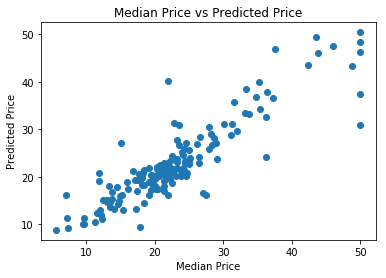

In [20]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## 可选步骤：清理数据

SageMaker 上的默认 notebook 实例没有太多的可用磁盘空间。当你继续完成和执行 notebook 时，最终会耗尽磁盘空间，导致难以诊断的错误。完全使用完 notebook 后，建议删除创建的文件。你可以从终端或 notebook hub 删除文件。以下单元格中包含了从 notebook 内清理文件的命令。

In [21]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir